In [1]:
# !pip install numpy==1.19.5
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random as rd
import tensorflow as tf

from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dense

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [2]:
with open ('data_kia.csv', 'r') as f:
    l = f.readline()
    i = l.split(",")
    
    for n, v in enumerate(i):
        print(f"{n}: {v}")

0: Fuel_consumption
1: Accelerator_Pedal_value
2: Throttle_position_signal
3: Short_Term_Fuel_Trim_Bank1
4: Intake_air_pressure
5: Filtered_Accelerator_Pedal_value
6: Absolute_throttle_position
7: Engine_soacking_time
8: Inhibition_of_engine_fuel_cut_off
9: Engine_in_fuel_cut_off
10: Fuel_Pressure
11: Long_Term_Fuel_Trim_Bank1
12: Engine_speed
13: Engine_torque_after_correction
14: Torque_of_friction
15: Flywheel_torque_(after_torque_interventions)
16: Current_spark_timing
17: Engine_coolant_temperature
18: Engine_Idel_Target_Speed
19: Engine_torque
20: Calculated_LOAD_value
21: Minimum_indicated_engine_torque
22: Maximum_indicated_engine_torque
23: Flywheel_torque
24: Torque_scaling_factor(standardization)
25: Standard_Torque_Ratio
26: Requested_spark_retard_angle_from_TCU
27: TCU_requests_engine_torque_limit_(ETL)
28: TCU_requested_engine_RPM_increase
29: Target_engine_speed_used_in_lock-up_module
30: Glow_plug_control_request
31: Activation_of_Air_compressor
32: Torque_converter_spe

In [13]:
def import_data():
    """
    Import data and split into features and labels
    """
    data = pd.read_csv('data_kia.csv').values
    x_data = data[:, :51]
    y_data = data[:, 52]
    return x_data, y_data

data, labels = import_data()
data

array([[268.8, 0.0, 5.2, ..., -8.8, 0, -3.4],
       [243.2, 0.0, 6.1, ..., -0.2, 0, -3.6],
       [217.6, 0.0, 5.2, ..., -0.2, 0, -3.6],
       ...,
       [345.6, 0.0, 6.6, ..., 0.0, 0, -13.2],
       [332.8, 0.0, 5.7, ..., 0.0, 0, -13.3],
       [281.6, 0.0, 5.2, ..., -0.1, 0, -13.3]], dtype=object)

In [14]:
scaler = preprocessing.MinMaxScaler().fit(data)

In [15]:
def normalize_data(rows, max_columns=None, min_columns=None):
    try:
        if max_columns == None:
            max_columns = rows.max(axis=0)
    except:
        pass
    
    try:
        if min_columns == None:
            min_columns = rows.min(axis=0)
    except:
        pass
    norm_rows = np.empty(rows.shape)
    for i in range(rows.shape[1]):
        for j in range(rows.shape[0]):
            if ((max_columns[i]-min_columns[i])>0):
                norm_rows[j][i] = (rows[j][i] - min_columns[i])/(max_columns[i]-min_columns[i])
            else:
                norm_rows[j][i] = 0
    return norm_rows, max_columns, min_columns

normal_data, max_columns, min_columns = normalize_data(data)
normal_data


array([[0.02459016, 0.        , 0.052     , ..., 0.07650273, 0.        ,
        0.49030656],
       [0.02224824, 0.        , 0.061     , ..., 0.54644809, 0.        ,
        0.49011556],
       [0.01990632, 0.        , 0.052     , ..., 0.54644809, 0.        ,
        0.49011556],
       ...,
       [0.03161593, 0.        , 0.066     , ..., 0.55737705, 0.        ,
        0.48094738],
       [0.03044496, 0.        , 0.057     , ..., 0.55737705, 0.        ,
        0.48085188],
       [0.02576112, 0.        , 0.052     , ..., 0.55191257, 0.        ,
        0.48085188]])

In [16]:
def onehot_labels(labels, num_labels=10, skip=8):
    """
    Converts label array to 1-hot encoded vectors
    """

    result = []

    for l in labels:
        label_vector = [0] * num_labels
        index = ord(l) - ord('A')
        label_vector[index] = 1

        result.append(label_vector)

    return np.array([result[i] for i in range(0, len(result) - 16, skip)])

# y_data = tf.convert_to_tensor(onehot_labels(labels), dtype=tf.float64)
y_data = onehot_labels(labels)
len(y_data)

11796

In [17]:
def package_data(data, window_size=16):
    result = []
    for i in range(0, len(data) - window_size, window_size // 2):
        result.append(data[i:i + window_size])

    return (result)
# x_data = tf.convert_to_tensor(package_data(normal_data), dtype=tf.float64)
x_data = package_data(data)
len(x_data)

11796

In [18]:

def add_noise(data, noise_level, std_level):
    noise_map = np.random.rand(data.shape[0], data.shape[1])

    non_noise_indices = np.where(noise_map > noise_level)
    
    noise = np.random.normal(0, std_level, data.shape)
    noise[non_noise_indices] = 0

    return data + noise
   


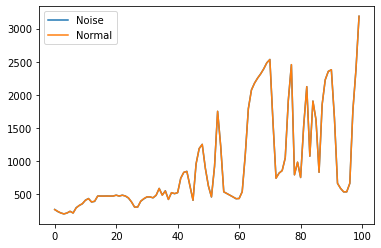

In [35]:
plt.plot(noisy_data[:100, 0])
plt.plot(data[:100, 0])
plt.legend(["Noise", "Normal"])
plt.show()

In [19]:
# create train and test batches
x_train, x_test, y_train, y_test = train_test_split(
    x_data, y_data[:], test_size=0.10
)

x_train = normalize_data(np.array(x_train), max_columns, min_columns)[0]
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

print(x_train.shape), print(x_test.shape)
print(y_train.shape, y_test.shape)

(10616, 16, 51)
(1180, 16, 51)
(10616, 10) (1180, 10)


In [20]:
def create_model(learning_rate=1e-4, window_size=16, num_features=51):
    model = Sequential()
    model.add(LSTM(160, input_shape=(window_size, num_features), return_sequences=True ))
    model.add(LSTM(200, ))

    model.add(Dense(10, activation="sigmoid"))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss="categorical_crossentropy", metrics=['categorical_crossentropy'])

    return model

In [21]:
model = create_model()
model.fit(x_train, y_train, epochs=250, batch_size=128, validation_split=(0.05/0.9))

Epoch 1/250
79/79 [==============================] - 7s 57ms/step - loss: 2.2696 - categorical_crossentropy: 2.2696 - val_loss: 2.2438 - val_categorical_crossentropy: 2.2438
Epoch 2/250
79/79 [==============================] - 4s 47ms/step - loss: 2.2183 - categorical_crossentropy: 2.2183 - val_loss: 2.1807 - val_categorical_crossentropy: 2.1807
Epoch 3/250
79/79 [==============================] - 4s 49ms/step - loss: 2.1301 - categorical_crossentropy: 2.1301 - val_loss: 2.1063 - val_categorical_crossentropy: 2.1063
Epoch 4/250
79/79 [==============================] - 4s 49ms/step - loss: 2.0704 - categorical_crossentropy: 2.0704 - val_loss: 2.0543 - val_categorical_crossentropy: 2.0543
Epoch 5/250
79/79 [==============================] - 4s 48ms/step - loss: 2.0013 - categorical_crossentropy: 2.0013 - val_loss: 1.9891 - val_categorical_crossentropy: 1.9891
Epoch 6/250
79/79 [==============================] - 4s 49ms/step - loss: 1.9387 - categorical_crossentropy: 1.9387 - val_loss: 1.

In [34]:
data_sets = []
std_levels = [0, 0.0625, 0.125, 0.3125, 0.5, 0.7, 0.8, 0.9, 1.0, 2.0]
for i in std_levels:
    data_sets.append(normalize_data(add_noise(x_test, 1, i), max_columns=max_columns, min_columns=min_columns)[0])
    
packaged_data = []
for data_set in data_sets:
    packaged_data.append(np.array(data_set))

In [35]:
predictions = []
for i, p in enumerate(packaged_data):
    print(i)
    predictions.append(model.predict(p[:]))


0
1
2
3
4
5
6
7
8
9


In [36]:
percentages = []

for j, prediction in enumerate(predictions):
    correct_count = 0

    for i, p in enumerate(prediction):
        # check if predicted labels is the same as test label
        if np.argmax(p) == np.argmax(y_test[i]):
            correct_count += 1
    
    percentages.append(correct_count/len(prediction))
# print(f"Accuracy: {correct_count} / {len(prediction)} = {correct_count / len(prediction) * 100:.2f}%")

percentages

[0.6805084745762712,
 0.6779661016949152,
 0.6822033898305084,
 0.6771186440677966,
 0.676271186440678,
 0.6644067796610169,
 0.673728813559322,
 0.6677966101694915,
 0.6550847457627119,
 0.5915254237288136]

[0, 0.0625, 0.125, 0.3125, 0.5, 0.7, 0.8, 0.9, 1.0, 2.0]


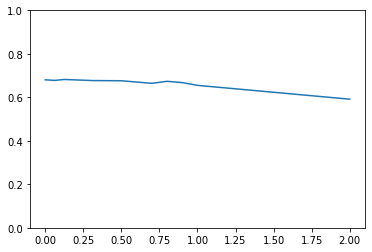

In [37]:
print(std_levels)
plt.plot(std_levels, percentages)
plt.ylim((0.0, 1.0))
plt.show()

In [38]:
for d in data_sets:
    plt.plot(d[:100, 43])
    plt.show()

IndexError: index 43 is out of bounds for axis 1 with size 16

In [39]:
model.save("99accuracy.h5")